In [15]:
### GLOWORM SWARM OPTIMIZATION EXAMPLE
### LUKE PETERSON 06/30/2016
### INFO: https://en.wikipedia.org/wiki/Glowworm_swarm_optimization
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import simpy

In [16]:
##############################################################################
# GSO PARAMETERS 
##############################################################################
dims = 10
num_worms = 20
nturns = 100
lower_bound = 70
influence_factor = 30
max_jitter = 0.2

In [17]:
##############################################################################
# Fitness Function 
##############################################################################
def fitness_function(xy_tuple):
    x = xy_tuple[0]/2
    y = xy_tuple[1]/2
    return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

In [18]:
##############################################################################
# Keep the swarm do not go beyond the boundary
##############################################################################
def keep_in_bounds(x, dims):
    if x < 0:
        return 0
    elif x > dims:
        return dims
    else:
        return x

In [19]:
##############################################################################
# GSO FUNCTIONS 
##############################################################################
class Glowworm:
    def __init__(self, env, name, swarm, X=np.array([1, 1]), waypoint = np.array([250,250]),  speed=1.5433, 
                 transRange=2.0, score = 0.0):
        self.env = env
        self.name = name
        self.swarm = swarm  # List of all particles
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.waypoint = waypoint

        self.X = X
        self.V = np.random.randn(2) * 0.1
        self.score = score # for 
        self.influenceDict = {name: 0.0}

        self.positions = [self.X.copy()]
        self.process = env.process(self.run())

    def sensing(self): # 
        """accquire the fitness of worm's current position to calculate 'influence radius'."""
        shifted = fitness_function(self.X) + lower_bound
        self.score = shifted / influence_factor

    def send(self):
        """If worm j is within worm j's radius, record distance; else 0. For influence martrix"""
        for glowworm in self.swarm:
            distance = dist.euclidean(self.X, glowworm.X)
            if distance <= self.transmission_range:
                self.influenceDict[glowworm.name] = distance
            if glowworm.name == self.name:
                self.influenceDict[self.name] = 0.0

    def receive(self, nbest_position, nbest_fitness, isTarget):
        """update the personal nbest"""
        if nbest_fitness < self.nbest_fitness:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
            self.targetFounded = isTarget

    def movement(self):
        """Update each worm's position based on the dict of influences."""
        new_position = np.array([0.0, 0.0])
        x_move = 0.0
        y_move = 0.0
        for glowworm in self.swarm:
            if self.influenceDict.get(glowworm.name) is not None:
                if self.influenceDict[glowworm.name] != 0 and self.score < glowworm.score:
                    percent_move = 1 - (self.influenceDict[glowworm.name] / glowworm.score)
                    x_move += (glowworm.X[0] - self.X[0]) * percent_move / 10
                    y_move += (glowworm.X[1] - self.X[1]) * percent_move / 10
        
        # Add random jitter
        jitter_x = max_jitter * np.random.rand() * np.random.randint(-1,2)
        jitter_y = max_jitter * np.random.rand() * np.random.randint(-1,2)
        
        new_position[0] = self.X[0] + x_move + jitter_x
        new_position[1] = self.X[1] + y_move + jitter_y
        
        # Bound checking
        new_position[0] = keep_in_bounds(new_position[0], dims)
        new_position[1] = keep_in_bounds(new_position[1], dims)

        self.X = new_position

    ##############################################################################
    # SIMPY INTEGRATION
    ##############################################################################
    def run(self):
        """
        A generator (process) that runs GSO for 'nturns' iterations in a SimPy environment.
        Each iteration is considered one time-step in the simulation.
        """
        i = 0
        while True:
            # Compute glowworm logic
            self.sensing()
            self.send()
            self.movement()

            # Store positions for later analysis or plotting    
            self.positions.append(self.X.copy()) # take the records of position
            i = i + 1

            # Advance simulated time by 1 time unit
            yield self.env.timeout(1)


In [20]:
def starting_points(num_worms):
    """Initialize the worm positions randomly."""
    return np.random.rand(num_worms, 2) * dims

In [21]:
def run_gso_simpy():
    """
    Sets up the SimPy environment, runs the glowworm process,
    and returns the recorded positions.
    """
    sim_env = simpy.Environment()

    # Initial population
    pop = starting_points(num_worms)

    # x, y = np.array(np.meshgrid(np.linspace(0, 500, 5000), np.linspace(0, 500, 5000)))
    # z = fitness_function([x, y])
    # x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]
    # target_position = np.array([x_min, y_min])  # Define the target position
    # target_fitness = fitness_function([x_min, y_min])

    # Create and start the GSO process
    swarm = []    
    for i in range(num_worms):
        swarm.append(Glowworm(env = sim_env, name = i, swarm = [], X=pop[i]))

    for glowworm in swarm:
        glowworm.swarm = swarm  # Give each glowworm the list of all glowworm
        #particle.target = [target_position,target_fitness]

    # Run the simulation
    sim_env.run(until=nturns)

    swarm_positions = []
    for glowworm in swarm:
        swarm_positions.append(glowworm.positions)

    return swarm_positions

In [24]:
##############################################################################
# MAIN (Demo)
##############################################################################
if __name__ == "__main__":
    all_positions = run_gso_simpy()

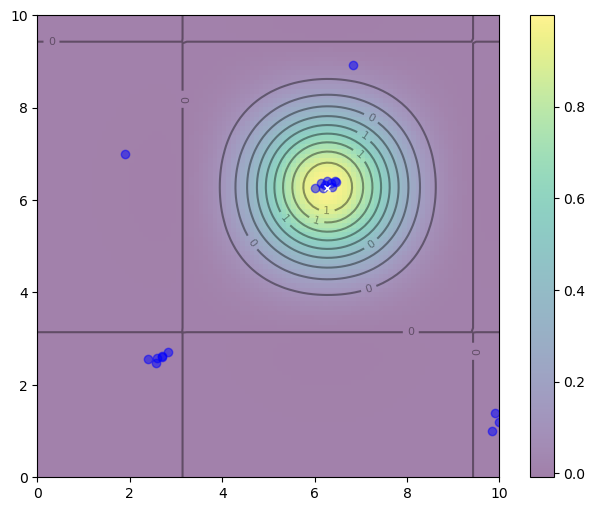

In [25]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function([x, y])
x_max, y_max = x.ravel()[z.argmax()], y.ravel()[z.argmax()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
#p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
#nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

i = 100
ax.clear()
ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
x_list = []
y_list = []
for j in range(num_worms):
    x_list.append(all_positions[j][i][0])
    y_list.append(all_positions[j][i][1])
p_plot = ax.scatter(x_list, y_list, marker='o', color='blue', alpha=0.5)
#nbest_plot.set_offsets(nbest.reshape(1, -1))
plt.show()